# Stock Analysis Using LSTM - MVP (LATEST)
- train an LSTM on a variable number of features
- vary on lookback (LSTM window) and training window (years before present date)
- multi input version
- multi day lookahead (predict x days ahead) version

This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [633]:
import pandas as pd
import numpy as np
import os
import yaml
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
look_back = 3
config_file = 'model_training_config.yml'

In [634]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [635]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [636]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [637]:
# switches
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
# e.g. company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
continuouscols = config['categorical']
textcols = config['text']
collist = config['continuous']
years_window = config['general']['years_window']
quandl_token = config['general']['quandl_token']
# number of days previous used to predict subsequent day
look_back = config['general']['look_back']
# gap in day betwen the last day previous and the subsequent day being predicted
look_ahead = config['general']['look_ahead']
years_winow = config['general']['years_window']
# target column
lstm_target = config['general']['lstm_target']
# list from target column
lstm_target_list = [lstm_target]
# additional features beyond the target column
feature_list = config['general']['feature_list']
# complete list of features LSTM trained on
lstm_feature_list = lstm_target_list+feature_list
# switch to determine normalization method
min_max_norm = config['general']['min_max_norm']


In [638]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'min_max_norm': True,
  'master_start': '2018-01-01',
  'ust_cols': ['2 YR'],
  'years_window': 2,
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'look_back': 3,
  'look_ahead': 7,
  'lstm_target': 'Close',
  'feature_list': ['2 YR',
   '30 YR',
   'Bullish',
   'Bearish',
   'unemployment',
   'gdp',
   'cpi']},
 'files': {'saved_model_modifier': 'January312021'},
 'tech_list': ['CROX', 'SHAK'],
 'compa

# Load US Treasury stats

In [639]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [640]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,0.03,0.03,0.05,0.07,0.08,0.13,0.27,0.71,1.12,1.45,2.11,2.23
2021-03-02,0.04,0.04,0.04,0.06,0.08,0.13,0.26,0.67,1.08,1.42,2.09,2.21
2021-03-03,0.04,0.04,0.05,0.07,0.08,0.14,0.29,0.73,1.14,1.47,2.12,2.25


In [641]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


# Load consumer sentiment


In [642]:
# from https://www.quandl.com/data/UMICH/SOC22-University-of-Michigan-Consumer-Survey-Current-Market-Value-of-Primary-Residence
# ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
# authtoken=quandl_token
conf_df = quandl.get("UMICH/SOC22", authtoken=quandl_token)

In [643]:
conf_df.head()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
1990-08-31,60.0,23.0,10.0,1.0,0.0,1.0,5.0,41521.0,75457.0,124447.0,82926.0
1993-11-30,54.0,27.0,7.0,3.0,1.0,3.0,5.0,44000.0,82333.0,149820.0,105820.0
1993-12-31,53.0,28.0,9.0,2.0,1.0,1.0,6.0,50514.0,83693.0,150990.0,100476.0
1994-01-31,57.0,21.0,9.0,4.0,0.0,1.0,8.0,49963.0,80484.0,132046.0,82083.0
1994-02-28,55.0,29.0,7.0,2.0,2.0,2.0,3.0,56000.0,86300.0,148333.0,92333.0


In [644]:
conf_df.tail()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
2020-09-30,8.0,19.0,20.0,15.0,9.0,24.0,5.0,176594.0,295738.0,495580.0,318987.0
2020-10-31,8.0,20.0,17.0,16.0,11.0,23.0,5.0,175380.0,300500.0,477137.0,301757.0
2020-11-30,8.0,15.0,21.0,15.0,9.0,26.0,6.0,198333.0,302360.0,501011.0,302677.0
2020-12-31,10.0,17.0,22.0,18.0,9.0,21.0,3.0,180926.0,289556.0,440000.0,259074.0
2021-01-31,8.0,18.0,18.0,17.0,10.0,23.0,6.0,181345.0,300875.0,473333.0,291989.0


In [645]:
conf_df.shape

(202, 11)

# Parameters to incorporate
- Investor sentiment: https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
- GDP: https://www.quandl.com/data/FRED/GDP-Gross-Domestic-Product
- Consumer Price Index (as proxy for inflation): https://www.quandl.com/data/FRED/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items (I think these figures are derived from the same source I put in the factor spreadsheet: https://www.bls.gov/news.release/cpi.toc.htm)
- Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

# Load investor sentiment

In [646]:
# investor sentiment
# https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
# weekly
inv_sent_df = quandl.get("AAII/AAII_SENTIMENT", authtoken=quandl_token)
inv_sent_df.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.379704,0.480209,0.2792,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.379704,0.480209,0.2792,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.379704,0.480209,0.2792,323.00,316.23,323.00


In [647]:
inv_sent_df.tail()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
2021-01-28,0.376623,0.240260,0.383117,1.000000,0.444499,-0.006494,0.379704,0.480209,0.2792,3870.90,3732.48,3750.77
2021-02-04,0.373529,0.270588,0.355882,0.999999,0.436613,0.017647,0.379704,0.480209,0.2792,3847.51,3694.12,3830.17
2021-02-11,0.454545,0.282828,0.262626,0.999999,0.438407,0.191919,0.379704,0.480209,0.2792,3931.50,3816.68,3909.88
2021-02-18,0.470588,0.275542,0.253870,1.000000,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33
2021-02-25,0.459283,0.302932,0.237785,1.000000,0.438476,0.221498,0.379704,0.480209,0.2792,3924.30,3911.13,3924.30


In [648]:
inv_sent_df.shape

(1754, 12)

In [649]:
inv_sent_df.index

DatetimeIndex(['1987-06-26', '1987-07-17', '1987-07-24', '1987-07-31',
               '1987-08-07', '1987-08-14', '1987-08-21', '1987-08-28',
               '1987-09-04', '1987-09-11',
               ...
               '2020-12-17', '2020-12-24', '2020-12-31', '2021-01-07',
               '2021-01-21', '2021-01-28', '2021-02-04', '2021-02-11',
               '2021-02-18', '2021-02-25'],
              dtype='datetime64[ns]', name='Date', length=1754, freq=None)

In [650]:
# infill weekly time series to daily
# try  resample approach: https://stackoverflow.com/questions/55901304/pandas-resample-from-weekly-to-daily-with-offset
# df = df.resample('D', loffset=offset).ffill()
inv_sent_df2 = inv_sent_df.resample('D').ffill()

inv_sent_df2

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,NaN,NaN,NaN
1987-06-27,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,NaN,NaN,NaN
1987-06-28,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,NaN,NaN,NaN
1987-06-29,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,NaN,NaN,NaN
1987-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.379704,0.480209,0.2792,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-21,0.470588,0.275542,0.253870,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33
2021-02-22,0.470588,0.275542,0.253870,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33
2021-02-23,0.470588,0.275542,0.253870,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33


In [651]:

 ust_df.shape

(7799, 12)

# Load GDP

In [652]:
gdp_df = quandl.get("FRED/GDP", authtoken=quandl_token)
gdp_df.tail()

,Value
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21487.896


In [653]:
gdp_df.rename(columns={'Value':'gdp'}, inplace=True)
gdp_df.tail()

,gdp
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21487.896


In [654]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-06')

In [655]:
gdp_df.loc[add_date] = [21487.896]

In [656]:
gdp_df = gdp_df.resample('D').ffill()
gdp_df.tail()

,gdp
Date,
2021-03-02,21487.896
2021-03-03,21487.896
2021-03-04,21487.896
2021-03-05,21487.896
2021-03-06,21487.896


# Load CPI

In [657]:
cpi_df = quandl.get("FRED/CPIAUCSL", authtoken=quandl_token)
cpi_df.tail()

,Value
Date,
2020-09-01,260.149
2020-10-01,260.462
2020-11-01,260.927
2020-12-01,261.560
2021-01-01,262.231


In [658]:
cpi_df.rename(columns={'Value':'cpi'}, inplace=True)

In [659]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-06')

In [660]:
cpi_df.loc[add_date] = [262.231]

In [661]:
cpi_df = cpi_df.resample('D').ffill()
cpi_df.tail()

,cpi
Date,
2021-03-02,262.231
2021-03-03,262.231
2021-03-04,262.231
2021-03-05,262.231
2021-03-06,262.231


# Load unemployment

In [662]:
# Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate
# monthly
unemp_df = quandl.get("FRED/UNRATE")
unemp_df.tail()

,Value
Date,
2020-10-01,6.9
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2


In [663]:
unemp_df.rename(columns={'Value':'unemployment'}, inplace=True)

In [664]:
unemp_df.index

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01'],
              dtype='datetime64[ns]', name='Date', length=878, freq=None)

In [665]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-06')

In [666]:
unemp_df.loc[add_date] = [6.2]

In [667]:
unemp_df.tail()

,unemployment
Date,
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2
2021-03-06,6.2


In [668]:
unemp_df = unemp_df.resample('D').ffill()
unemp_df.tail()

,unemployment
Date,
2021-03-02,6.2
2021-03-03,6.2
2021-03-04,6.2
2021-03-05,6.2
2021-03-06,6.2


In [669]:
unemp_df.shape

(26729, 1)

# Join input dataframes

In [670]:
# do an inner join on Date column
ust_df = pd.merge(ust_df,inv_sent_df2,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.34,1.0,0.31250,0.01,0.379704,0.480209,0.2792,353.40,346.81,353.4
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.34,1.0,0.31250,0.01,0.379704,0.480209,0.2792,353.40,346.81,353.4
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.34,1.0,0.31250,0.01,0.379704,0.480209,0.2792,353.40,346.81,353.4
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.30,1.0,0.32875,0.10,0.379704,0.480209,0.2792,359.69,352.20,352.2
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.30,1.0,0.32875,0.10,0.379704,0.480209,0.2792,359.69,352.20,352.2


In [671]:
ust_df = pd.merge(ust_df,unemp_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-19,0.03,0.03,0.04,0.06,0.07,0.11,0.22,0.59,0.98,1.34,...,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2
2021-02-22,0.03,0.02,0.03,0.04,0.06,0.11,0.22,0.61,1.00,1.37,...,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2
2021-02-23,0.03,0.02,0.04,0.05,0.08,0.11,0.22,0.59,1.00,1.37,...,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2
2021-02-24,0.03,0.03,0.03,0.05,0.08,0.12,0.24,0.62,1.02,1.38,...,1.0,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2
2021-02-25,0.04,0.03,0.04,0.06,0.09,0.17,0.34,0.81,1.23,1.54,...,1.0,0.438476,0.221498,0.379704,0.480209,0.2792,3924.30,3911.13,3924.30,6.2


In [672]:
ust_df = pd.merge(ust_df,gdp_df,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.31250,0.01,0.379704,0.480209,0.2792,353.40,346.81,353.4,5.4,5872.701
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.31250,0.01,0.379704,0.480209,0.2792,353.40,346.81,353.4,5.4,5872.701
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.31250,0.01,0.379704,0.480209,0.2792,353.40,346.81,353.4,5.4,5872.701
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.32875,0.10,0.379704,0.480209,0.2792,359.69,352.20,352.2,5.4,5872.701
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.32875,0.10,0.379704,0.480209,0.2792,359.69,352.20,352.2,5.4,5872.701


In [673]:
ust_df.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-19,0.03,0.03,0.04,0.06,0.07,0.11,0.22,0.59,0.98,1.34,...,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896
2021-02-22,0.03,0.02,0.03,0.04,0.06,0.11,0.22,0.61,1.00,1.37,...,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896
2021-02-23,0.03,0.02,0.04,0.05,0.08,0.11,0.22,0.59,1.00,1.37,...,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896
2021-02-24,0.03,0.03,0.03,0.05,0.08,0.12,0.24,0.62,1.02,1.38,...,0.441332,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896
2021-02-25,0.04,0.03,0.04,0.06,0.09,0.17,0.34,0.81,1.23,1.54,...,0.438476,0.221498,0.379704,0.480209,0.2792,3924.30,3911.13,3924.30,6.2,21487.896


In [674]:
ust_df.shape

(7793, 26)

In [675]:
ust_df = pd.merge(ust_df,cpi_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp,cpi
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-19,0.03,0.03,0.04,0.06,0.07,0.11,0.22,0.59,0.98,1.34,...,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896,262.231
2021-02-22,0.03,0.02,0.03,0.04,0.06,0.11,0.22,0.61,1.00,1.37,...,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896,262.231
2021-02-23,0.03,0.02,0.04,0.05,0.08,0.11,0.22,0.59,1.00,1.37,...,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896,262.231
2021-02-24,0.03,0.03,0.03,0.05,0.08,0.12,0.24,0.62,1.02,1.38,...,0.216718,0.379704,0.480209,0.2792,3950.43,3884.94,3931.33,6.2,21487.896,262.231
2021-02-25,0.04,0.03,0.04,0.06,0.09,0.17,0.34,0.81,1.23,1.54,...,0.221498,0.379704,0.480209,0.2792,3924.30,3911.13,3924.30,6.2,21487.896,262.231


# Define start and end of analysis period

In [676]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - years_window, end.month, end.day)
tester = DataReader('AAPL', 'yahoo', start, end)
tester.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-06,43.872501,43.485001,43.667500,43.630001,83241600.0,42.735043
2019-03-07,43.610001,43.005001,43.467499,43.125000,99185600.0,42.240398
2019-03-08,43.267502,42.375000,42.580002,43.227501,95997600.0,42.340797
2019-03-11,44.779999,43.837502,43.872501,44.724998,128044000.0,43.807579
2019-03-12,45.667500,44.842499,45.000000,45.227501,129870400.0,44.299774


# Main model definition
- build dataframe containing all features
- define helper functions
- run main blocks to define and train model
- run block to visualize predictions

# Block to define main dataframe
- combine closing data dataframe with additional time series data (e.g. from quandl)

In [677]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
# start='2012-01-01'
for company in tech_list:
    df_predict[company] = DataReader(company,data_source='yahoo', start=start, end=datetime.now())
    # ezj["close"] / ezj["close"].shift() - 1
    df_predict[company]['Return'] = df_predict[company]['Close']/df_predict[company]['Close'].shift() -1
    df_predict[company]['Return'] = df_predict[company]['Return'].fillna(0.0)
    # check if anything being joined
    if len(feature_list) > 0:
        df_predict[company] = pd.merge(df_predict[company],ust_df[feature_list],on=['Date'],how='inner')
    # add
    # show an example
df_predict[tech_list[0]].head()

,High,Low,Open,Close,Volume,Adj Close,Return,2 YR,30 YR,Bullish,Bearish,unemployment,gdp,cpi
Date,,,,,,,,,,,,,,
2019-03-06,25.459999,24.600000,25.290001,24.940001,1570700,24.940001,0.000000,2.52,3.06,0.416327,0.200000,3.8,21115.309,254.147
2019-03-07,25.420000,24.790001,24.950001,25.370001,1071600,25.370001,0.017241,2.47,3.03,0.373860,0.267477,3.8,21115.309,254.147
2019-03-08,25.500000,24.820000,25.250000,25.180000,1232300,25.180000,-0.007489,2.45,3.00,0.373860,0.267477,3.8,21115.309,254.147
2019-03-11,25.280001,24.719999,25.180000,24.959999,1649400,24.959999,-0.008737,2.47,3.03,0.373860,0.267477,3.8,21115.309,254.147
2019-03-12,25.049999,24.459999,24.930000,24.900000,1117200,24.900000,-0.002404,2.45,3.00,0.373860,0.267477,3.8,21115.309,254.147


# Define helper functions
- define helper functions used by main model training block

In [678]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [679]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [680]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [681]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [682]:
def multi_col_df(df,cols):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    #print("data inside is:",data)
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [683]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [684]:
def scale_data(dataset):
    if min_max_norm:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [685]:
def create_x_y(scaled_data,training_data_len,look_back,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - look_ahead - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i+look_ahead, 0])
        

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [686]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [687]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [688]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [689]:
# from https://stackoverflow.com/questions/53049396/sklearn-inverse-transform-return-only-one-column-when-fit-to-many
def invTransform(scaler, data, colName, colNames):
    # wrapper function to get inverse transform on one column from a dataframe that has been scaled
    # - scaler   = the scaler object (it needs an inverse_transform method)
    # - data     = the data to be inverse transformed as a Series, ndarray, ... 
    #              (a 1d object you can assign to a df column)
    # - ftName   = the name of the column to which the data belongs
    # - colNames = all column names of the data on which scaler was fit 
    #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

# Main model definition and training block

In [690]:
%%time
# train models for each company in tech_list and save trained models
predictions = {}
data = {}
for company in tech_list:
    data[company],dataset,training_data_len = multi_col_df(df_predict[company],lstm_feature_list)
    # X, dictlist get_keras_vars(df_predict[company])
    #print("dataset is: ",dataset)
    #print(("data[company] is:",data[company]))
    print("training_data_len: ",training_data_len)
    print("dataset shape: ",str(dataset.shape))
    print("data[company] shape: ",str(data[company].shape))
    #scaled_data, scaler = scale_data(dataset)
    scaled_data, scaler = scale_data(data[company])
    x_train, y_train = create_x_y(scaled_data,training_data_len,look_back,len(lstm_feature_list))
    #print("x_train is: ",x_train)
    #print("y_train is: ",y_train)
    print("x_train shape: ",x_train.shape)
    print("y_train shape: ",y_train.shape)
    print("TRAINING LOOP FOR: ",str(company))
    '''
    turn off for experiment with multi columns
    '''
    if use_saved_model:
        # put here
        save_model_path = get_save_model_path(company)
        model = load_model(save_model_path)
    else:
        # train model fresh
        #Build the LSTM model
        model = build_model_func(x_train,y_train,'adam','mean_squared_error',len(lstm_feature_list))
        # save the model
        save_model(model,company)
    #Create a new array containing scaled values from index 1543 to 2002 
    
    test_data = scaled_data[training_data_len - look_back: , :]
    #Create the data sets x_test and y_test
    print("about to run test loop")
    x_test = []
    y_test = []
    # y_test = dataset[training_data_len:, :]
    for i in range(len(test_data)-look_ahead):
        y_test.append(test_data[i+look_ahead, 0])
    
    
    
    print("look_back is", look_back)
    print("shape of test_data is ",str(test_data.shape))
    print("len(test_data) is ",len(test_data))
    for i in range(look_back,len(test_data)):
        a = test_data[i-look_back:i, :]
        x_test.append(a)
    print("shape of a is ",str(a.shape))
    print("after test loop")
    '''
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    '''
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    print("x_test shape",x_test.shape)
    print("y_test shape",y_test.shape)
    # Reshape the data
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions_temp = model.predict(x_test)
    print("after predictions_temp")
    print("predictions temp shape ",predictions_temp.shape)
    #print("prediction_temp: ",predictions_temp)
    # invTransform(scaler, data, colName, colNames)
    # predictions[company] = scaler.inverse_transform(predictions_temp)
    predictions[company] = invTransform(scaler,predictions_temp,lstm_target,lstm_feature_list)
    print("predictions company shape ",predictions[company].shape)
    predictions[company] = np.reshape(predictions[company], (predictions[company].shape[0],1))
    print("predictions company shape 2 ",predictions[company].shape)
    

cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
training_data_len:  396
dataset shape:  (495, 8)
data[company] shape:  (495, 8)
scaled_data shape:  (495, 8)
training_data_len:  396
train_data shape is:  (396, 8)
len(train_data):  396
x_train shape:  (385, 3, 8)
y_train shape:  (385,)
TRAINING LOOP FOR:  CROX
Epoch 1/1
385/385 [==============================] - 15s 39ms/step - loss: 0.0049
Saved model with name  CROXMarch062021.h5
about to run test loop
look_back is 3
shape of test_data is  (102, 8)
len(test_data) is  102
shape of a is  (3, 8)
after test loop
x_test shape (99, 3, 8)
y_test shape (95,)
after predictions_temp
predictions temp shape  (99, 1)
predictions company shape  (99,)
predictions company shape 2  (99, 1)
cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
training_data_len:  396
dataset shape:  (495, 8)
data[company] shape:  (495, 8)
scaled_data shape:  (495, 8)
training_data_len:  396
train_

In [691]:
x_test

array([[[0.36631046, 0.02057613, 0.20772947, ..., 0.38053097,
         0.74087587, 0.74245423],
        [0.32966926, 0.00823045, 0.20289855, ..., 0.38053097,
         0.74087587, 0.74245423],
        [0.32539447, 0.01646091, 0.22705314, ..., 0.38053097,
         0.74087587, 0.74245423]],

       [[0.32966926, 0.00823045, 0.20289855, ..., 0.38053097,
         0.74087587, 0.74245423],
        [0.32539447, 0.01646091, 0.22705314, ..., 0.38053097,
         0.74087587, 0.74245423],
        [0.32936393, 0.02057613, 0.22222222, ..., 0.30088496,
         0.88349107, 0.78117269]],

       [[0.32539447, 0.01646091, 0.22705314, ..., 0.38053097,
         0.74087587, 0.74245423],
        [0.32936393, 0.02057613, 0.22222222, ..., 0.30088496,
         0.88349107, 0.78117269],
        [0.34870229, 0.01646091, 0.23671498, ..., 0.30088496,
         0.88349107, 0.78117269]],

       ...,

       [[0.92162853, 0.00823045, 0.52657005, ..., 0.23893805,
         0.88349107, 1.        ],
        [0.93669217, 

# Plotting block
- for each model trained, plot the actual for history and, for validation period, actual vs. prediciton
- display key parameters

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


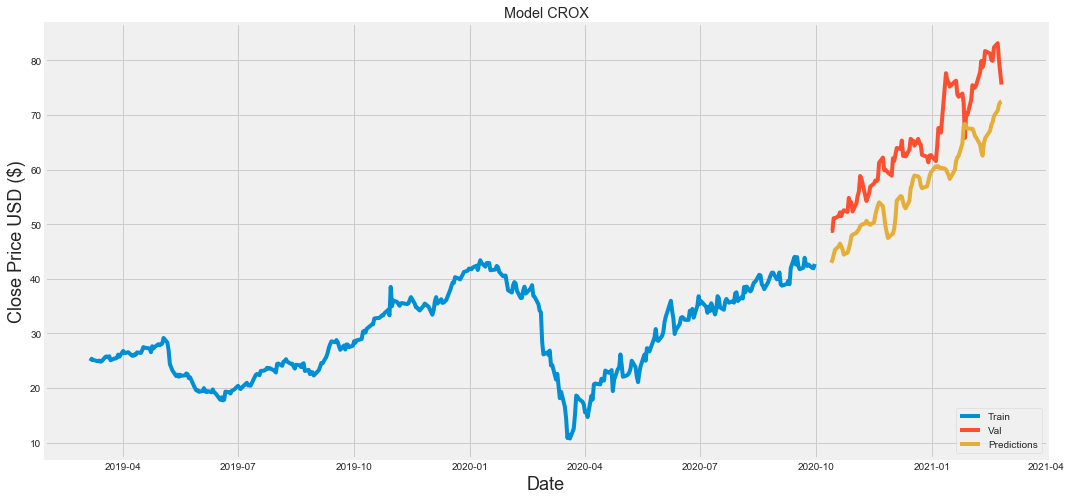

LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
lookback is:  3
lookahead is:  7
years_window is:  2
normalization method:  min_max


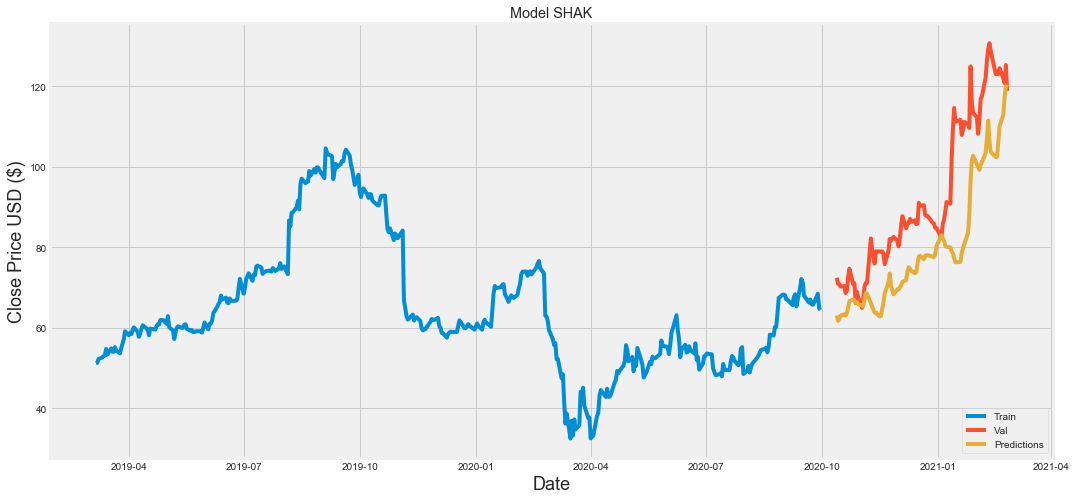

LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
lookback is:  3
lookahead is:  7
years_window is:  2
normalization method:  min_max


In [692]:
# Plot the data

for company in tech_list:
    train = data[company][:training_data_len]
    #valid = data[company][training_data_len:]
    valid = data[company][training_data_len+look_ahead:]
    #train = np.reshape(train,(train.shape[0],1))
    #valid = np.reshape(valid,(valid.shape[0],1))
    #print("train shape ",train.shape)
    #print("valid shape ",valid.shape)
    #print("predictions[company] shape ",predictions[company].shape)
    #print("things you want ",str(predictions[company].shape[0]-look_ahead))
    valid['Predictions'] = predictions[company][:predictions[company].shape[0]-look_ahead]
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model'+" "+company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(lstm_target+' Price USD ($)', fontsize=18)
    plt.plot(train[lstm_target])
    plt.plot(valid[[lstm_target, 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print("LSTM target is: ",lstm_target)
    print("LSTM features are: ",lstm_feature_list)
    print("lookback is: ",str(look_back))
    print("lookahead is: ",str(look_ahead))
    print("years_window is: ",str(years_window))
    if min_max_norm:
        norm = "min_max"
    else:
        norm = "standardization"
    print("normalization method: ",norm)